In [ ]:
# Mount Google Drive to save data and models
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to your Google Drive
import os
os.chdir('/content/drive/My Drive/AIML')

Mounted at /content/drive


In [ ]:
# Install necessary libraries
!pip install wfdb numpy pandas matplotlib

# Import required libraries
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 4.2 MB/s eta 0:00:00


In [1]:
import wfdb
from wfdb import get_record_list
import os

# Create a folder to store the dataset
os.makedirs("mit-bih-arrhythmia-database", exist_ok=True)

# Download the dataset
wfdb.dl_database("mitdb", "mit-bih-arrhythmia-database")

ModuleNotFoundError: No module named 'wfdb'

Record Name: 100
Sampling Frequency: 360 Hz
Signal Shape: (650000, 2)
Available Channels: ['MLII', 'V5']


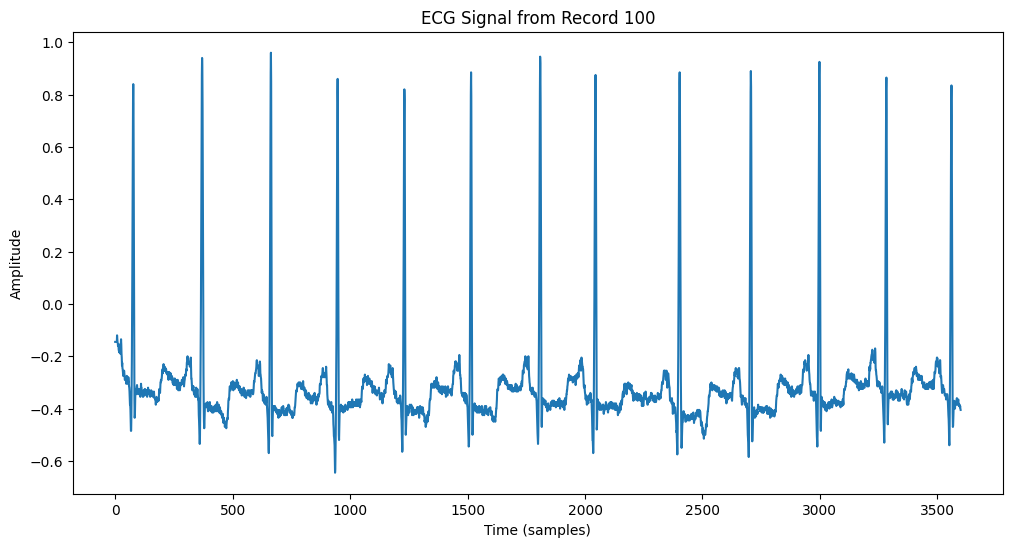

In [ ]:
# Load a sample record
record_name = 'mit-bih-arrhythmia-database/100'
record = wfdb.rdrecord(record_name)
annotation = wfdb.rdann(record_name, 'atr')

# Display record information
print(f"Record Name: {record.record_name}")
print(f"Sampling Frequency: {record.fs} Hz")
print(f"Signal Shape: {record.p_signal.shape}")
print(f"Available Channels: {record.sig_name}")

# Plot the first 10 seconds of the signal
plt.figure(figsize=(12, 6))
plt.plot(record.p_signal[:record.fs * 10, 0])
plt.title(f"ECG Signal from Record {record.record_name}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

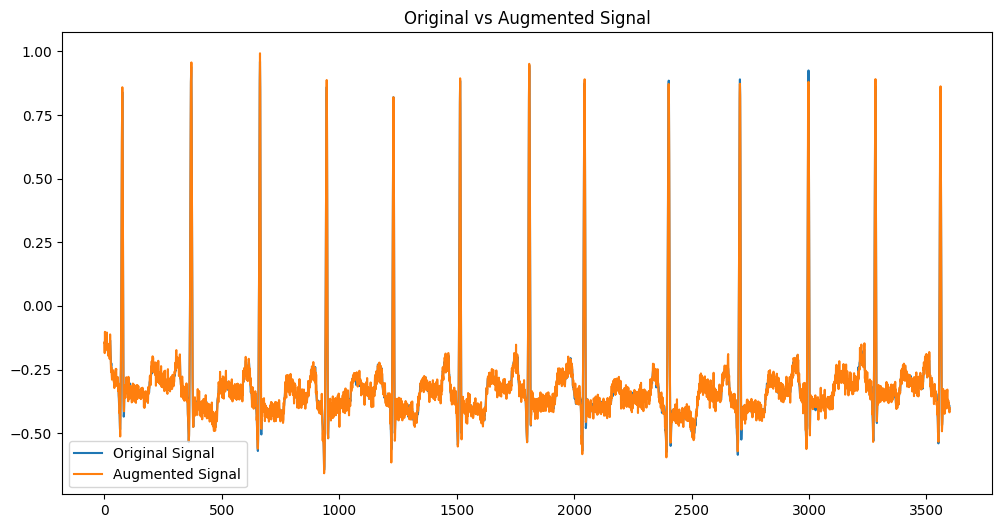

In [ ]:
def augment_signal(signal, method='noise', scale=0.01):
    if method == 'noise':
        return signal + np.random.normal(0, scale, size=signal.shape)
    elif method == 'scaling':
        return signal * np.random.uniform(0.9, 1.1)
    elif method == 'shift':
        return np.roll(signal, shift=int(scale * len(signal)))

# Example: Apply augmentation
augmented_signal = augment_signal(record.p_signal[:, 0], method='noise', scale=0.02)

# Visualize original vs augmented
plt.figure(figsize=(12, 6))
plt.plot(record.p_signal[:record.fs * 10, 0], label='Original Signal')
plt.plot(augmented_signal[:record.fs * 10], label='Augmented Signal')
plt.legend()
plt.title("Original vs Augmented Signal")
plt.show()

In [ ]:
# Extract time-series features with corrected RR interval calculation
def extract_features(record, annotation):
    sampling_rate = record.fs
    r_peaks = annotation.sample  # R-peak indices

    # Compute RR intervals
    if len(r_peaks) > 1:
        rr_intervals = np.diff(r_peaks) / sampling_rate  # Convert to seconds
        mean_rr = np.mean(rr_intervals)
        sdnn = np.std(rr_intervals)  # HRV: Standard Deviation of RR Intervals
    else:
        rr_intervals = []
        mean_rr = 0
        sdnn = 0

    # Collect features in a dictionary
    features = {
        "Mean RR Interval (s)": mean_rr,
        "SDNN (Standard Deviation of RR Intervals) (s)": sdnn,
        "Mean Signal Amplitude": np.mean(record.p_signal[:, 0]),
        "Signal Amplitude Std Dev": np.std(record.p_signal[:, 0]),
    }
    return features

# Extract features again
features = extract_features(record, annotation)
print("Corrected Extracted Features:")
for key, value in features.items():
    print(f"{key}: {value:.3f}")

Corrected Extracted Features:
Mean RR Interval (s): 0.794
SDNN (Standard Deviation of RR Intervals) (s): 0.051
Mean Signal Amplitude: -0.306
Signal Amplitude Std Dev: 0.193


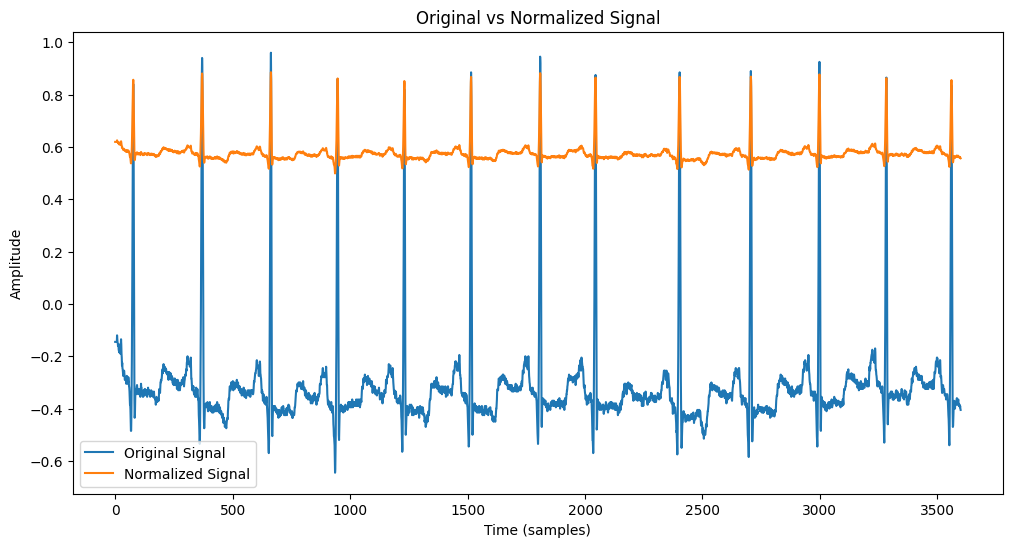

In [ ]:
# Normalize the signal
def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

# Normalize the signal from the sample record
normalized_signal = normalize_signal(record.p_signal[:, 0])

# Plot original and normalized signals
plt.figure(figsize=(12, 6))
plt.plot(record.p_signal[:record.fs * 10, 0], label="Original Signal")
plt.plot(normalized_signal[:record.fs * 10], label="Normalized Signal")
plt.title("Original vs Normalized Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [ ]:
# Save preprocessed data
def save_preprocessed_data(record_name, annotation, output_file):
    signal = normalize_signal(record.p_signal[:, 0])
    r_peaks = annotation.sample

    # Create a DataFrame for the preprocessed signal
    df = pd.DataFrame({
        "Time (s)": np.arange(len(signal)) / record.fs,
        "Signal": signal,
        "R-Peak": [1 if i in r_peaks else 0 for i in range(len(signal))]
    })



    df.to_csv(output_file, index=False)
    print(f"Preprocessed data saved to {output_file}")

save_preprocessed_data(record_name, annotation, "preprocessed_100.csv")

Preprocessed data saved to preprocessed_100.csv


Time increments are correct!
Signal values are correctly normalized between 0 and 1!


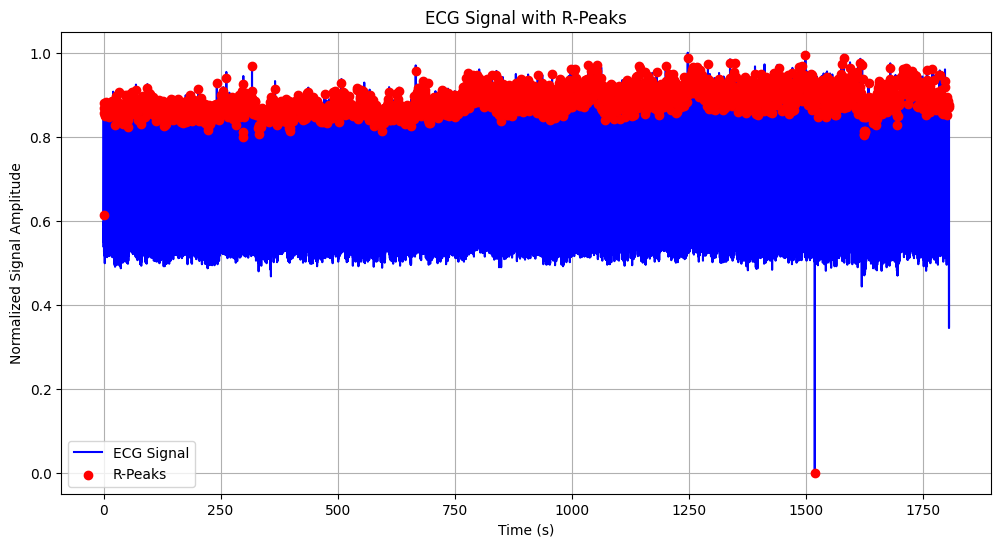

In [ ]:
import pandas as pd

# Load the preprocessed data
preprocessed_data = pd.read_csv("preprocessed_100.csv")

# Calculate time increments
time_differences = preprocessed_data["Time (s)"].diff().dropna()

# Expected sampling interval (e.g., for 360 Hz)
expected_interval = 1 / 360

# Check if all time differences match the expected interval
if all(abs(time_differences - expected_interval) < 1e-6):
    print("Time increments are correct!")
else:
    print("Time increments do not match the expected sampling frequency!")

# Check signal range
if preprocessed_data["Signal"].between(0, 1).all():
    print("Signal values are correctly normalized between 0 and 1!")
else:
    print("Signal values are out of the expected range (0 to 1)!")

import matplotlib.pyplot as plt

# Extract data
time = preprocessed_data["Time (s)"]
signal = preprocessed_data["Signal"]
r_peaks = preprocessed_data["R-Peak"]

# Plot the ECG signal
plt.figure(figsize=(12, 6))
plt.plot(time, signal, label="ECG Signal", color='blue')

# Overlay R-peaks
r_peak_times = time[r_peaks == 1]
r_peak_values = signal[r_peaks == 1]
plt.scatter(r_peak_times, r_peak_values, color='red', label="R-Peaks", zorder=3)

# Add labels and legend
plt.title("ECG Signal with R-Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Signal Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
r_peak_indices = preprocessed_data[preprocessed_data["R-Peak"] == 1].index
r_peak_intervals = np.diff(r_peak_indices) / record.fs  # Convert to seconds
print(f"Average RR Interval: {np.mean(r_peak_intervals):.2f} seconds")

Average RR Interval: 0.79 seconds


In [ ]:
# Load original annotation data (assuming you already have `annotation.sample`)
r_peaks_original = annotation.sample

# Convert original R-peaks to time
r_peaks_original_time = r_peaks_original / record.fs  # record.fs is the sampling frequency

# Compare R-peak times with the preprocessed data
preprocessed_r_peak_times = preprocessed_data.loc[preprocessed_data["R-Peak"] == 1, "Time (s)"]

# Allow small tolerance for matching (due to sampling differences)
tolerance = 0.01  # 10 ms tolerance
matching_r_peaks = sum(any(abs(t - original) < tolerance for original in r_peaks_original_time)
                       for t in preprocessed_r_peak_times)

print(f"Number of correctly matched R-peaks: {matching_r_peaks} out of {len(r_peaks_original_time)}")

Number of correctly matched R-peaks: 2274 out of 2274


In [ ]:
import glob
import os

# Path to the dataset folder
dataset_path = "mit-bih-arrhythmia-database"
output_path = "preprocessed_data"

# Create output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Process all records in the dataset
record_files = glob.glob(os.path.join(dataset_path, "*.dat"))

for record_file in record_files:
    record_name = os.path.splitext(os.path.basename(record_file))[0]
    try:
        # Load record and annotation
        record = wfdb.rdrecord(os.path.join(dataset_path, record_name))
        annotation = wfdb.rdann(os.path.join(dataset_path, record_name), 'atr')

        # Extract features
        features = extract_features(record, annotation)
        print(f"Features for record {record_name}: {features}")

        # Save preprocessed data
        output_file = os.path.join(output_path, f"preprocessed_{record_name}.csv")
        save_preprocessed_data(record_name, annotation, output_file)
        print(f"Preprocessed data saved for {record_name}.")

    except Exception as e:
        print(f"Error processing record {record_name}: {e}")

Features for record 105: {'Mean RR Interval (s)': 0.6708725733168112, 'SDNN (Standard Deviation of RR Intervals) (s)': 0.12380198267666472, 'Mean Signal Amplitude': -0.22515476153846153, 'Signal Amplitude Std Dev': 0.40508494143776236}
Preprocessed data saved to preprocessed_data/preprocessed_105.csv
Preprocessed data saved for 105.
Features for record 115: {'Mean RR Interval (s)': 0.9206059833418324, 'SDNN (Standard Deviation of RR Intervals) (s)': 0.10093752813649641, 'Mean Signal Amplitude': -0.48810586153846164, 'Signal Amplitude Std Dev': 0.36343399973387935}
Preprocessed data saved to preprocessed_data/preprocessed_115.csv
Preprocessed data saved for 115.
Features for record 231: {'Mean RR Interval (s)': 0.8980168601437257, 'SDNN (Standard Deviation of RR Intervals) (s)': 0.13177089936806397, 'Mean Signal Amplitude': -0.15817635384615383, 'Signal Amplitude Std Dev': 0.27196043633236466}
Preprocessed data saved to preprocessed_data/preprocessed_231.csv
Preprocessed data saved for 

In [ ]:
import pandas as pd
import glob

# Path to the dataset folder
dataset_path = "mit-bih-arrhythmia-database"
output_path = "preprocessed_data"

# Create output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Process all records in the dataset
record_files = glob.glob(os.path.join(dataset_path, "*.dat"))

# Path to save aggregated features
features_file = os.path.join(output_path, "aggregated_features.csv")

# Aggregate features
all_features = []

for record_file in record_files:
    record_name = os.path.splitext(os.path.basename(record_file))[0]
    try:
        # Load record and annotation
        record = wfdb.rdrecord(os.path.join(dataset_path, record_name))
        annotation = wfdb.rdann(os.path.join(dataset_path, record_name), 'atr')

        # Extract features and append to list
        features = extract_features(record, annotation)
        features["Record Name"] = record_name
        all_features.append(features)

    except Exception as e:
        print(f"Error extracting features from {record_name}: {e}")

# Save aggregated features to CSV
features_df = pd.DataFrame(all_features)
features_df.to_csv(features_file, index=False)
print(f"Aggregated features saved to {features_file}.")

Aggregated features saved to preprocessed_data/aggregated_features.csv.


In [ ]:
from sklearn.model_selection import train_test_split

# Load aggregated features
features_df = pd.read_csv(features_file)

# Example target creation: classify based on SDNN threshold (adjust for your use case)
features_df["Target"] = (features_df["SDNN (Standard Deviation of RR Intervals) (s)"] > 0.05).astype(int)

# Split into train and test sets
train_df, test_df = train_test_split(features_df, test_size=0.2, random_state=42)

# Save train and test sets
train_df.to_csv(os.path.join(output_path, "train_features.csv"), index=False)
test_df.to_csv(os.path.join(output_path, "test_features.csv"), index=False)
print("Train and test datasets saved.")

Train and test datasets saved.


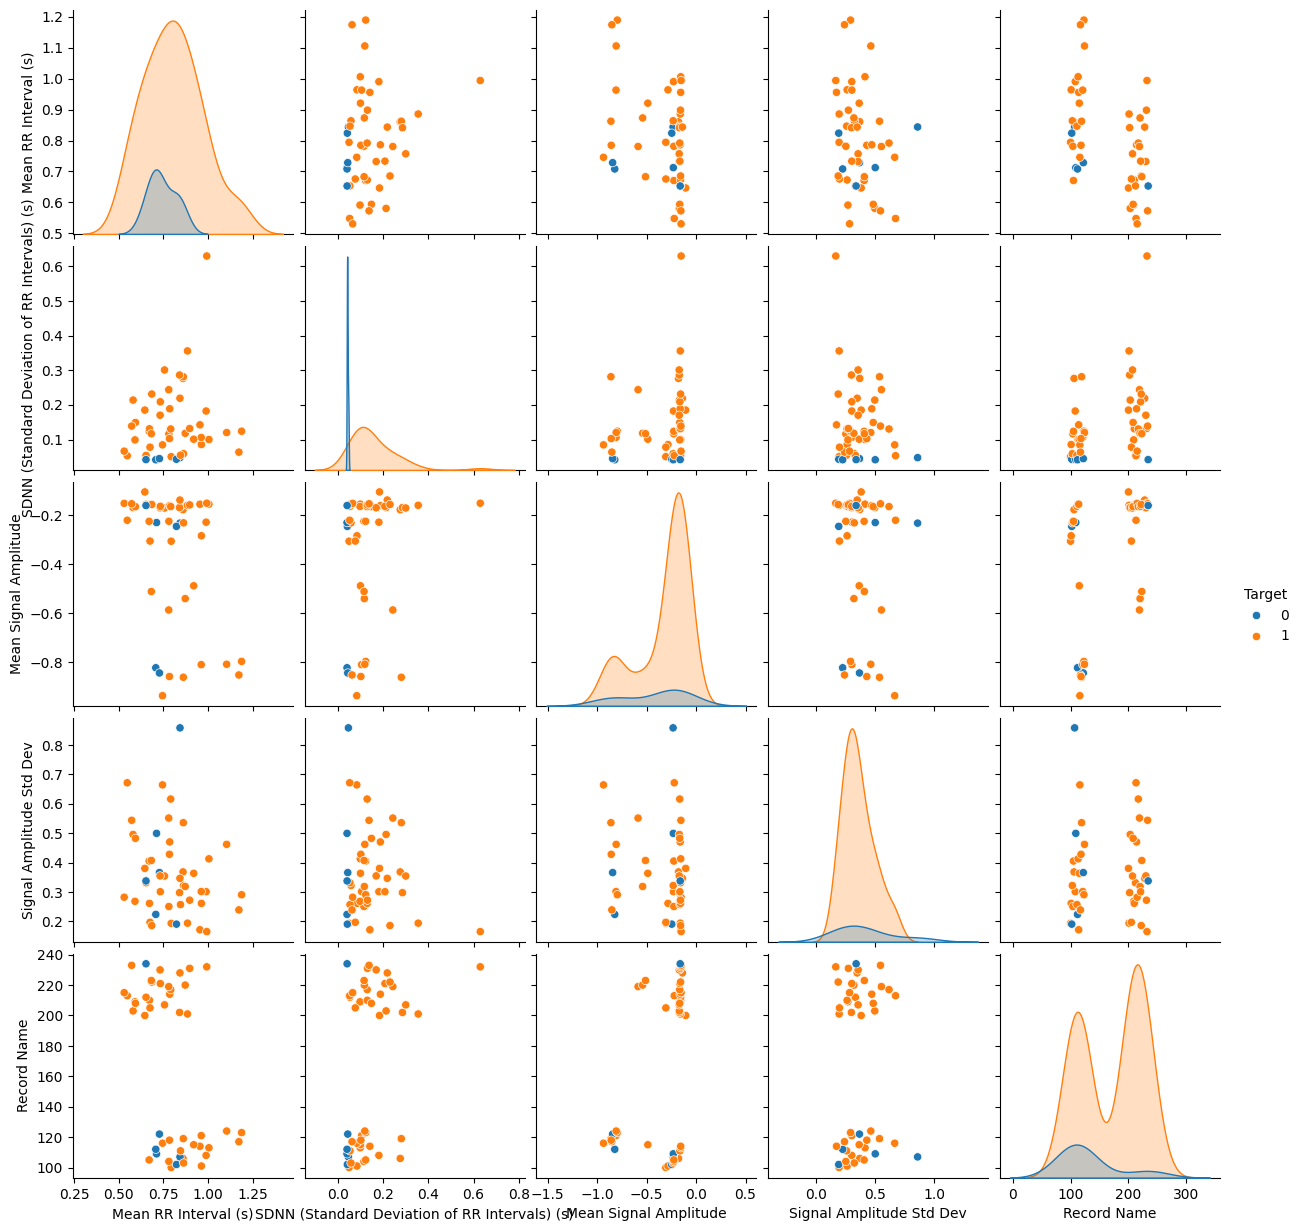

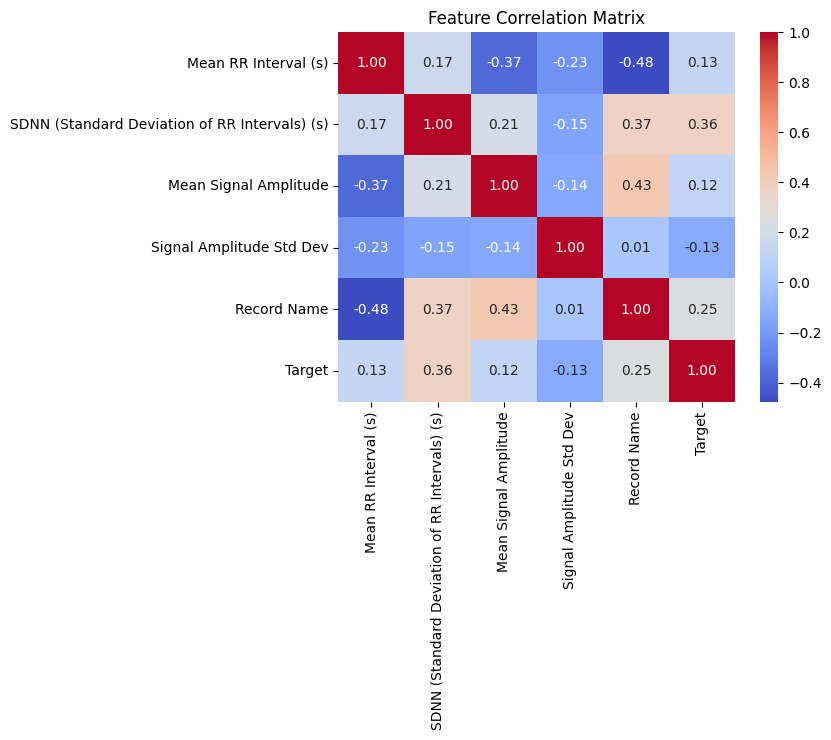

In [ ]:
import seaborn as sns

# Visualize feature distribution
sns.pairplot(features_df, hue="Target", diag_kind="kde")
plt.show()

# Correlation heatmap
sns.heatmap(features_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Load aggregated features
features_df = pd.read_csv("preprocessed_data/aggregated_features.csv")

# Example: Use SDNN threshold as the target label (1 for abnormal, 0 for normal)
# Adjust threshold based on medical knowledge
features_df["Target"] = (features_df["SDNN (Standard Deviation of RR Intervals) (s)"] > 0.1).astype(int)

# Drop unnecessary columns (e.g., Record Name)
features_df = features_df.drop(columns=["Record Name"])

# Split into train and test sets
X = features_df.drop(columns=["Target"])
y = features_df["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Test Set Size: {X_test.shape[0]} samples")

Training Set Size: 38 samples
Test Set Size: 10 samples


In [ ]:
!pip install --upgrade xgboost
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 23.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score

# Use top features based on importance
top_features = ["SDNN (Standard Deviation of RR Intervals) (s)", "Mean RR Interval (s)"]
X_reduced = X[top_features]


# Replace XGBClassifier with HistGradientBoostingClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
hist_model = HistGradientBoostingClassifier(random_state=42)

stacking_model = StackingClassifier(
    estimators=[('rf', rf_model), ('hist', hist_model)],
    final_estimator=RandomForestClassifier(n_estimators=50, random_state=42)
)

# Cross-validation with error handling
stacking_scores = cross_val_score(
    stacking_model, X_reduced, y, cv=5, scoring='accuracy', error_score="raise"
)
print("Stacking Model Cross-Validation Scores:", stacking_scores)
print("Stacking Model Mean Accuracy:", stacking_scores.mean())

Stacking Model Cross-Validation Scores: [1.         1.         1.         0.88888889 1.        ]
Stacking Model Mean Accuracy: 0.9777777777777779


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.89      1.00      0.94         8

    accuracy                           0.90        10
   macro avg       0.94      0.75      0.80        10
weighted avg       0.91      0.90      0.89        10

Confusion Matrix:
[[1 1]
 [0 8]]


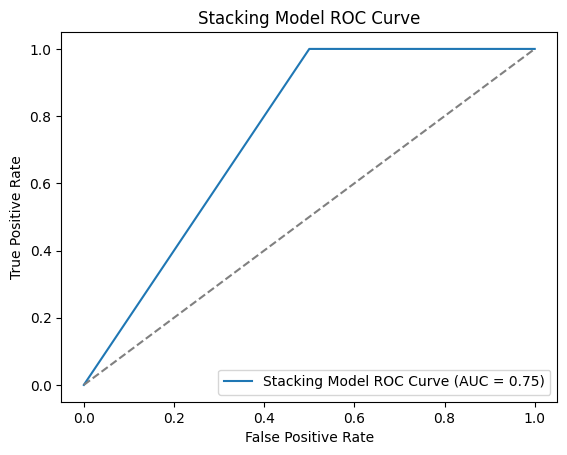

In [ ]:
# Fit the stacking model on the full training set
stacking_model.fit(X_train, y_train)

# Evaluate on test set
y_test_pred = stacking_model.predict(X_test)
y_test_proba = stacking_model.predict_proba(X_test)[:, 1]

# Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'Stacking Model ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking Model ROC Curve')
plt.legend()
plt.show()

In [ ]:
import joblib

# Save the trained stacking model
joblib.dump(stacking_model, "stacking_model.pkl")

# Load the saved stacking model
stacking_model = joblib.load("stacking_model.pkl")

print("Model saved and loaded successfully.")

Model saved and loaded successfully.


In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(stacking_model, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print("Feature Importances (Permutation):")
print(importance_df)

Feature Importances (Permutation):
                                         Feature  Importance
1  SDNN (Standard Deviation of RR Intervals) (s)        0.16
0                           Mean RR Interval (s)        0.00
2                          Mean Signal Amplitude        0.00
3                       Signal Amplitude Std Dev        0.00


In [ ]:
import numpy as np
import pandas as pd
import wfdb
import os

# Sliding window feature extraction
def sliding_window_features(signal, window_size=3600, step_size=360):
    features = []
    for start in range(0, len(signal) - window_size, step_size):
        window = signal[start:start + window_size]
        features.append([
            np.mean(window),  # Mean
            np.std(window),   # Standard Deviation
            np.max(window),   # Maximum
            np.min(window),   # Minimum
        ])
    return np.array(features)

# Extract features for all records
def extract_features_from_dataset(dataset_path, window_size=3600, step_size=360):
    all_features = []
    all_labels = []
    record_files = [os.path.splitext(f)[0] for f in os.listdir(dataset_path) if f.endswith('.dat')]

    for record_name in record_files:
        try:
            # Load signal and annotations
            record = wfdb.rdrecord(os.path.join(dataset_path, record_name))
            annotation = wfdb.rdann(os.path.join(dataset_path, record_name), 'atr')
            signal = record.p_signal[:, 0]  # Use the first signal channel (e.g., 'MLII')

            # Target label: Based on SDNN or other medical thresholds
            rr_intervals = np.diff(annotation.sample / record.fs)  # RR intervals in seconds
            sdnn = np.std(rr_intervals)  # Standard deviation of RR intervals
            label = 1 if sdnn > 0.1 else 0  # Example threshold

            # Extract sliding window features
            features = sliding_window_features(signal, window_size, step_size)

            # Append features and labels
            all_features.append(features)
            all_labels.extend([label] * len(features))  # Same label for all windows

        except Exception as e:
            print(f"Error processing record {record_name}: {e}")

    return np.vstack(all_features), np.array(all_labels)

# Extract features and labels
dataset_path = "mit-bih-arrhythmia-database"
X, y = extract_features_from_dataset(dataset_path)

print(f"Extracted {X.shape[0]} samples with {X.shape[1]} features.")

Extracted 86208 samples with 4 features.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Training Set Shape: {X_train.shape}")
print(f"Testing Set Shape: {X_test.shape}")

Training Set Shape: (68966, 4, 1)
Testing Set Shape: (17242, 4, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2156/2156 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.7076 - loss: 0.5675 - val_accuracy: 0.7856 - val_loss: 0.4089
Epoch 2/20
2156/2156 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - accuracy: 0.7990 - loss: 0.3915 - val_accuracy: 0.8335 - val_loss: 0.3235
Epoch 3/20
2156/2156 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.8404 - loss: 0.3369 - val_accuracy: 0.8678 - val_loss: 0.2800
Epoch 4/20
2156/2156 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.8590 - loss: 0.3058 - val_accuracy: 0.8812 - val_loss: 0.2662
Epoch 5/20
2156/2156 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8740 - loss: 0.2767 - val_accuracy: 0.8860 - val_loss: 0.2483
Epoch 6/20
2156/2156 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8792 - loss: 0.2631 - val_accuracy: 0.8836 - val_loss: 0.2465
Epoch 7/20
2156/2156 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.8853 - loss: 0.2588 - val_accuracy: 0.8986 - val_loss: 0.2279
Epoch 8/20
2156/2156 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8907 - loss: 0.2465 -

In [ ]:
# Save the model
model.save("lstm_model_updated.h5")

# Load the model for later use
from tensorflow.keras.models import load_model
model = load_model("lstm_model_updated.h5")

539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
539/539 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      6173
           1       0.93      0.94      0.94     11069

    accuracy                           0.92     17242
   macro avg       0.91      0.91      0.91     17242
weighted avg       0.92      0.92      0.92     17242

Confusion Matrix:
[[ 5435   738]
 [  700 10369]]


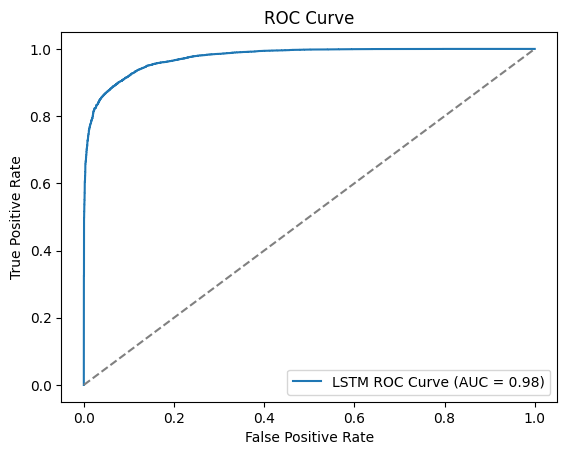

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_proba = model.predict(X_test).ravel()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"LSTM ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
!pip install keras-tuner
import kerastuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


<ipython-input-28-f4fc69484a61>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner


User Interface

In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib

# Load the stacking model
stacking_model = joblib.load("stacking_model.pkl")

# Validation function
def validate_csv(csv_file):
    """
    Validate the uploaded CSV file.
    Args:
        csv_file: Uploaded CSV file.
    Returns:
        Pandas DataFrame if valid, raises ValueError otherwise.
    """
    try:
        # Load the file
        data = pd.read_csv(csv_file.name)
        if "MLII" not in data.columns:
            raise ValueError("The uploaded CSV file must contain a column named 'MLII'.")

        # Check for missing or invalid values
        ml_signal = data["MLII"].values
        if np.isnan(ml_signal).sum() > 0 or np.isinf(ml_signal).sum() > 0:
            raise ValueError("The 'MLII' column contains invalid values (NaN or Inf).")

        return data
    except Exception as e:
        raise ValueError(f"Invalid CSV file: {e}")

# Preprocessing for Stacking Model
def preprocess_for_stacking(signal):
    """
    Preprocess the raw signal for the stacking model.
    """
    mean = np.mean(signal)
    std_dev = np.std(signal)
    max_val = np.max(signal)
    min_val = np.min(signal)

    if np.isnan(mean) or np.isinf(mean):
        raise ValueError("Invalid features extracted from the signal.")

    return np.array([mean, std_dev, max_val, min_val]).reshape(1, -1)

# Prediction function
def predict_disease(csv_file):
    """
    Predict cardiovascular disease using the stacking model.
    Args:
        csv_file: Uploaded CSV file.
    Returns:
        Prediction and probability.
    """
    try:
        # Validate the input
        data = validate_csv(csv_file)
        signal = data["MLII"].values

        # Preprocess for stacking
        features = preprocess_for_stacking(signal)
        print(f"Extracted Features: {features}")

        # Make predictions
        prediction = stacking_model.predict(features)[0]
        probabilities = stacking_model.predict_proba(features)[0]
        label = "Abnormal (Cardiovascular Disease Detected)" if prediction == 1 else "Normal (No Disease Detected)"
        return f"Prediction: {label}"
        #\nProbability of Abnormal: {probabilities[1]:.2f}"

    except Exception as e:
        return f"Error processing input: {str(e)}"

# Gradio interface
interface = gr.Interface(
    fn=predict_disease,
    inputs=gr.File(label="Upload ECG CSV File (e.g., 'MLII' column required)"),
    outputs="text",
    title="Cardiovascular Disease Detection",
    description=(
        "Upload an ECG signal file in `.csv` format containing raw signal data (column: 'MLII'). "
        "The model will process the data and predict whether cardiovascular disease is detected."
    )
)

# Launch the interface
interface.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ae271dcf81c69674b3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Extracted Features: [[0.1305     0.01430909 0.16       0.11      ]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(


Extracted Features: [[ 0.2125     0.4929186  0.9       -0.5      ]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
